# Introduction

This time we're going to try to implement a VAE! Once again, huge shoutout to pytorch for implementing a wide number of examples, including one for VAEs [here](https://github.com/pytorch/examples/blob/master/vae/main.py). The work here is largely based on that example.

In [0]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

same old dataloaders as before

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


let's take a quick look for comfort

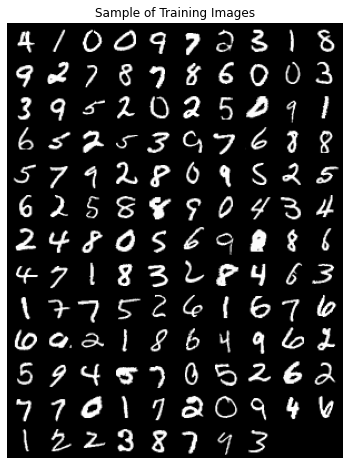

In [26]:
def view_batch(batch):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Sample of Training Images")
    plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, nrow=10).cpu(),(1,2,0)))
    plt.show()

view_batch(next(iter(loader))[0])

# Network

## Architecture

On a high level, our network is an encoder-decoder pair, designed so that the latent codes match a known distribution. 

Where it gets funky is that the outputs of our encoder is a $\mu$ mean vector and a $\sigma^2$ variance vector, so that our latent vector $z$ is given by $\mu + \sigma * \epsilon$, where $\epsilon$ is sampled from a normal distribution. This so called 'reparameterization trick' allows for a differentiable estimation of the expectation with respect to the parameters of our encoder. 

Recall that MNIST images are 28x28, so we can think of each input as a vector of length 784.

In [0]:
class VAE(nn.Module):
  def __init__(self, latent_dim=20):
    super(VAE, self).__init__()

    self.fc1 = nn.Linear(784, 500)
    self.fc2 = nn.Linear(500, 250)
    self.fc31 = nn.Linear(250, latent_dim) # outputs mu
    self.fc32 = nn.Linear(250, latent_dim) # outputs logvar (the log variance for z)
    self.fc4 = nn.Linear(latent_dim, 250)
    self.fc5 = nn.Linear(250, 500)
    self.fc6 = nn.Linear(500, 784)

  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    h2 = F.relu(self.fc2(h1))
    return self.fc31(h2), self.fc32(h2)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, z):
    h4 = F.relu(self.fc4(z))
    h5 = F.relu(self.fc5(h4))
    return torch.sigmoid(self.fc6(h5))

  def forward(self, x):
    mu, logvar = self.encode(x.view(-1, 784))
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [5]:
vae = VAE().to(device)
print(vae)

VAE(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc31): Linear(in_features=250, out_features=20, bias=True)
  (fc32): Linear(in_features=250, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=250, bias=True)
  (fc5): Linear(in_features=250, out_features=500, bias=True)
  (fc6): Linear(in_features=500, out_features=784, bias=True)
)


Cool, our VAE is pretty simple, with a depth of two for the encoder and decoder respectively. I added a parameter to define the length of our latent vector in case I want to investigate that more later. 

Edit: I've added a layer each to the encoder and decoder just to see what happens. The loss decreased by a little bit!

## Losses and Optimizer

In [10]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)

NameError: ignored

There are two components to our loss: reconstruction and distribution matching. The reconstruction refers to whether our autoencoder works; that is, how lossless our coding is. The second component uses [KL divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) to check how closely our latent codes match the desired distribution. 

In [0]:
def vae_loss(recon_x, x, mu, logvar):
    if recon_x.shape[1] == 784:
      BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    else:
      BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE, KLD

# Training

boiler plate training code

In [0]:
def train(loader, vae=None, latent_dim=20, lr=0.001, epochs=51, kld_weight=0.5):
  if vae is None:
    vae = VAE(latent_dim)
  vae.to(device)
  vae.train()
  optimizer = optim.Adam(vae.parameters(), lr=lr)

  fixed_latent_noise = torch.randn(50,latent_dim).to(device)
  recon_losses = []
  distr_losses = []
  losses = []

  for epoch in range(epochs):
    # # model.train()
    train_loss, recon_loss, distr_loss = 0, 0, 0 

    for (inputs, _) in loader:
      inputs = inputs.to(device)
      optimizer.zero_grad()
      recon_x, mu, logvar = vae(inputs)
      BCE, KLD = vae_loss(recon_x, inputs, mu, logvar)
      recon_loss += BCE.item()# (1-kld_weight) * BCE.item()
      distr_loss += KLD.item()# kld_weight * KLD.item()
      loss = (1-kld_weight) * BCE + kld_weight * KLD
      loss.backward()
      train_loss += loss.item()
      optimizer.step()
    recon_losses.append(recon_loss / len(loader.dataset))
    distr_losses.append(distr_loss / len(loader.dataset))
    losses.append(train_loss / len(loader.dataset))
    if epoch % 10 == 0:
      print('Epoch: {}......Loss: {:.8f}'.format(epoch, train_loss/len(loader.dataset)))
      with torch.no_grad():
        fake = vae.decode(fixed_latent_noise).detach().cpu().view(50,1,28,28)
      view_batch(fake)
  
  p1, = plt.plot(recon_losses, label='recon loss')
  p2, = plt.plot(distr_losses, label='distr loss')
  p3, = plt.plot(losses, label='overall loss')
  plt.title('Loss = {:.2f}*BCE + {:.2f}*KLD'.format(1-kld_weight, kld_weight))
  plt.legend(handles=[p1,p2,p3])
  plt.show()

  return vae

# trained_vae = train(loader)


# Experiments

Epoch: 0......Loss: 89.18211676


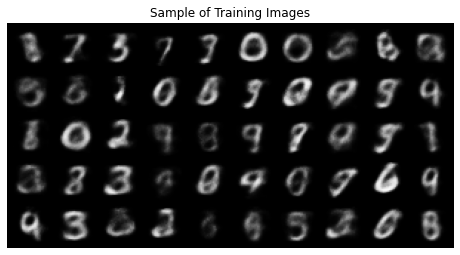

Epoch: 10......Loss: 51.98571796


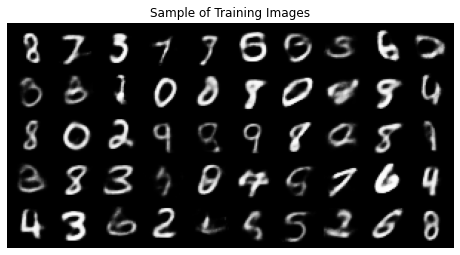

Epoch: 20......Loss: 50.09708402


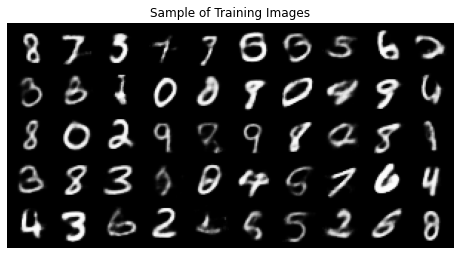

Epoch: 30......Loss: 49.27240842


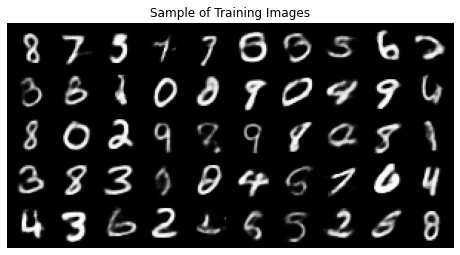

Epoch: 40......Loss: 48.82544009


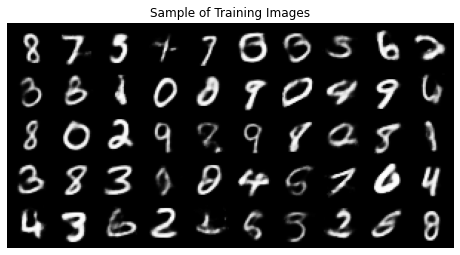

Epoch: 50......Loss: 48.47944210


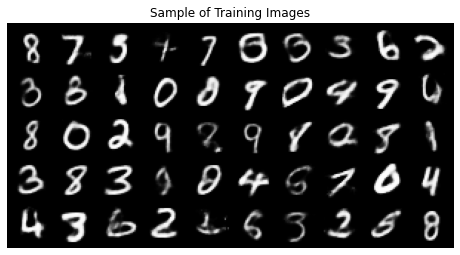

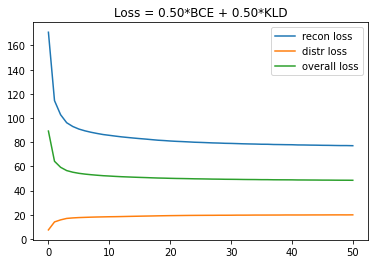

In [9]:
trained_vae = train(loader, lr=0.001)

Cool. My takeaways are that we don't gain that much after training around 20 epochs, so we'll stop there. Another takeaway is that our loss is dominated by the reconstruction loss. Let's assign weights differently - by setting the kld_weight hyperparameter to .9, the KL divergence loss will be weighted 9 times higher than the reconstruction loss.

Epoch: 0......Loss: 2.13133007


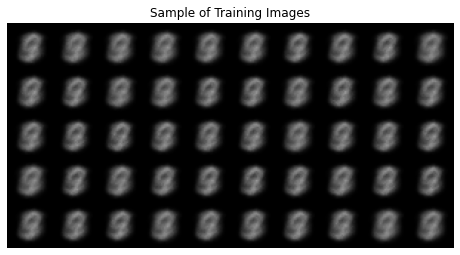

Epoch: 10......Loss: 2.06289878


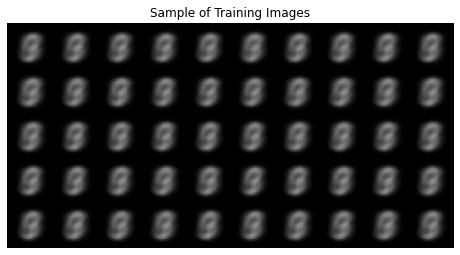

Epoch: 20......Loss: 2.06154767


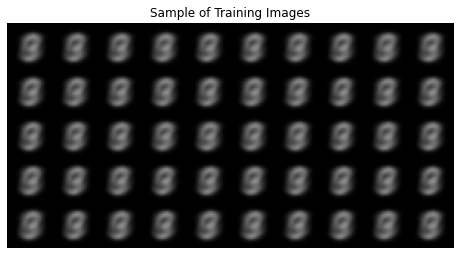

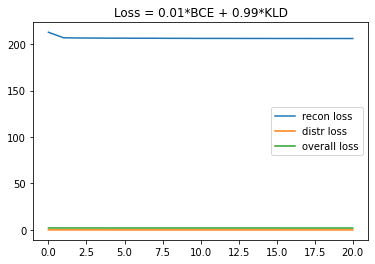

In [10]:
trained_vae2 = train(loader, epochs=21, kld_weight=0.99)

let's try again

Epoch: 0......Loss: 20.77664691


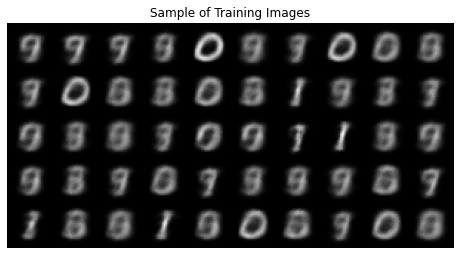

Epoch: 10......Loss: 17.87159308


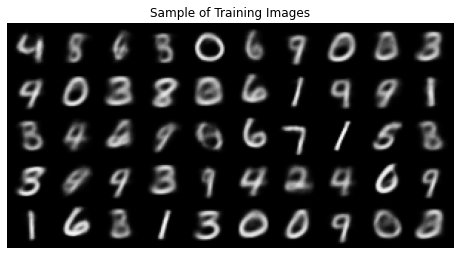

Epoch: 20......Loss: 17.68850852


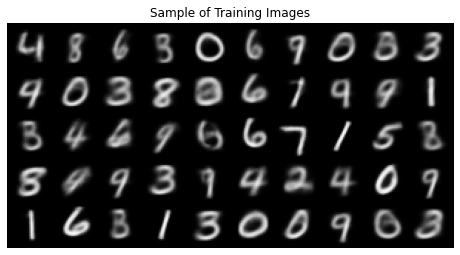

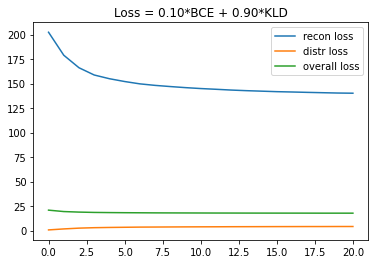

In [11]:
trained_vae2 = train(loader, epochs=21, kld_weight=0.9)

what happens if we weight the reconstruction loss higher? I think this will hurt our generative ability since we won't be able to match our distribution too well. Let's take a look.

Something important to note is that with these weights, we are essentially modifying the learning rate for each term. So in a sense, we aren't so much as weighting these terms differently, but just changing how fast we want to change our parameters based on feedback from specific losses.

Another interesting aspect is that the KLD loss starts at 0, so it cannot really be reduced in the early stages of training. For this reason, it seems like reconstruction is more important earlier on so that our decoder can work at all (generate realistic looking outputs). 

Epoch: 0......Loss: 128.85927980


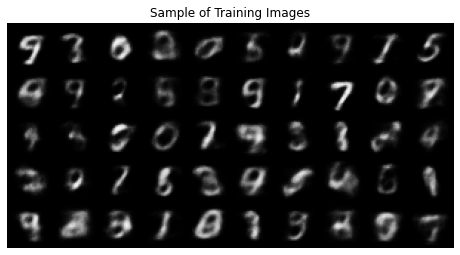

Epoch: 10......Loss: 63.17486813


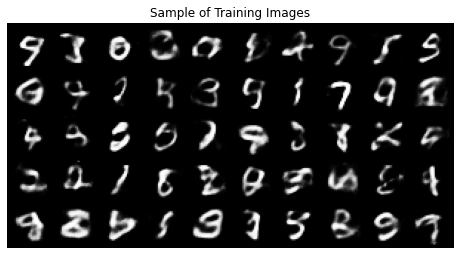

Epoch: 20......Loss: 61.09512910


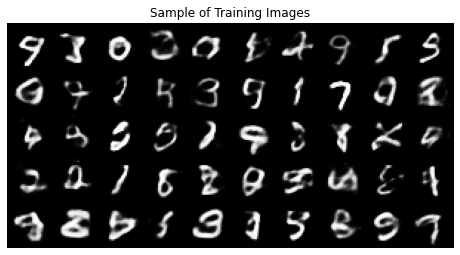

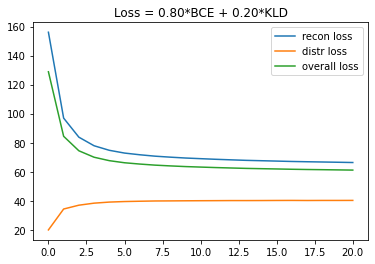

In [12]:
trained_vae3 = train(loader, epochs=21, kld_weight=0.2)

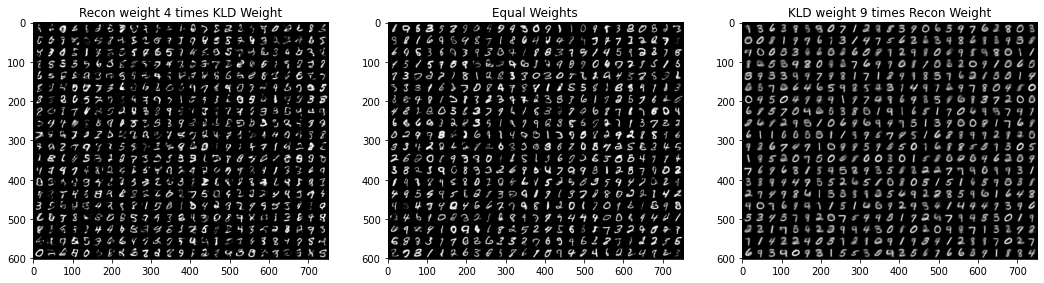

In [13]:
latent_code = torch.randn(500,20).to(device)
gen1, gen2, gen3 = [vae.decode(latent_code).detach().cpu().view(500,1,28,28) \
                    for vae in [trained_vae, trained_vae2, trained_vae3]]
plt.figure(figsize=(18,27))
plt.axis("off")
plt.subplot(131)
plt.title('Recon weight 4 times KLD Weight')
plt.imshow(np.transpose(vutils.make_grid(gen3, padding=2, nrow=25).cpu(),(1,2,0)))
plt.subplot(132)
plt.title('Equal Weights')
plt.imshow(np.transpose(vutils.make_grid(gen1, padding=2, nrow=25).cpu(),(1,2,0)))
plt.subplot(133)
plt.title('KLD weight 9 times Recon Weight')
plt.imshow(np.transpose(vutils.make_grid(gen2, padding=2, nrow=25).cpu(),(1,2,0)))
plt.show()

Ok, so what have we learned? I think the best one has the KLD learning rate higher than the recon learning rate, though with equal rates the results are still pretty good. It should be noted that each individual learning rate in these experiments is less than the baseline rate of 0.001, so maybe we would get different results with a different baseline rate. Playing with learning rates feels like one of the many aspects that makes deep learning experiments a black hole (since there are always more things to try). 

Hopefully one day I will have a stronger understanding of what shapes objective functions form so the optimization process is less mystified. 

Something else I think is interesting is how completely different encodings are learned in each trial (evident by the fact that the same random latent vector results in different generated numbers). This also makes me wary about deep learning, as exact training trajectories aren't designed to be reproducible with random batching. On one hand, the loss is still optimized in a very similar way in that the minimums they converge/end up on are close to one another, but the fact that these minimums are obtained with completely different encodings is curious. I wonder if these encodings are just like rotated versions of one another (i.e. they are clustered in the same way, but clusters map to different generated digits). 

Let's also see how well each network can reconstruct inputs. I'm more interested in the generative ability of VAEs, but reconstruction is still important, and it'll be interesting to see how the learning rate variations effects reconstructive ability (i.e. even with a lower recon lr, did we get to good reconstruction eventually? or is KLD and recon inversely related?)

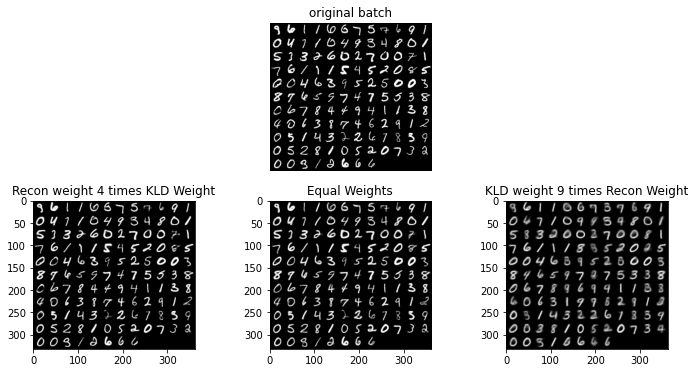

In [14]:
batch = next(iter(loader))[0].to(device)
# recon_batch, _, _ = trained_vae3(batch)
recon1, recon2, recon3 = [vae(batch)[0].detach().cpu().view(128,1,28,28) \
                          for vae in [trained_vae, trained_vae2, trained_vae3]]
plt.figure(figsize=(12,6))
plt.subplot(232)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch.cpu().view(128,1,28,28), padding=2, nrow=12).cpu(),(1,2,0)))
plt.title('original batch')
plt.subplot(234)
plt.title('Recon weight 4 times KLD Weight')
plt.imshow(np.transpose(vutils.make_grid(recon3, padding=2, nrow=12).cpu(),(1,2,0)))
plt.subplot(235)
plt.title('Equal Weights')
plt.imshow(np.transpose(vutils.make_grid(recon1, padding=2, nrow=12).cpu(),(1,2,0)))
plt.subplot(236)
plt.title('KLD weight 9 times Recon Weight')
plt.imshow(np.transpose(vutils.make_grid(recon2, padding=2, nrow=12).cpu(),(1,2,0)))
plt.show()

Very interesting! Reconstruction is definitely hurt when our KLD loss is weighted much higher than the reconstruction loss. My intuitive understanding of what's happening is that when we prioritize having our encoder output latent codes that match our distribution, we lose some specificty regarding our original outputs. Then, since our decoder has less specific information, it's outputs ultimately become more of an amalgamation of the different inputs that lead to the similar latent codes. This is why the outputs for the rightmost VAE seem kind of averaged. Notice that they are fuzzier and have less variance among them. My impression above (when I said I liked these results the best) was influenced by the fact that I wouldn't see anything obviously wrong, but now we can see that this comes at the cost of diverse outputs. 

# Interpolations

I'd love to get a better understanding of how our encoder is working, and in particular, what our latent space looks like. One way to peer inside is interpolations, where we take latent vectors along a line and decode them to see how the output changes. Let's give it a shot!

In [0]:
def interpolate(tens):
  out1, out2, out3 = [vae.decode(tens).detach().cpu().view(50,1,28,28) for vae in \
        [trained_vae, trained_vae2, trained_vae3]]
  plt.figure(figsize=(20,3))
  plt.subplot(311)
  plt.title('Recon weight 4 times KLD Weight')
  plt.imshow(np.transpose(vutils.make_grid(out3, padding=2, nrow=50).cpu(),(1,2,0)))
  plt.subplot(312)
  plt.title('Equal Weights')
  plt.imshow(np.transpose(vutils.make_grid(out1, padding=2, nrow=50).cpu(),(1,2,0)))
  plt.subplot(313)
  plt.title('KLD weight 9 times Recon Weight')
  plt.imshow(np.transpose(vutils.make_grid(out2, padding=2, nrow=50).cpu(),(1,2,0)))
  plt.show()

Line from all -1 to all 1


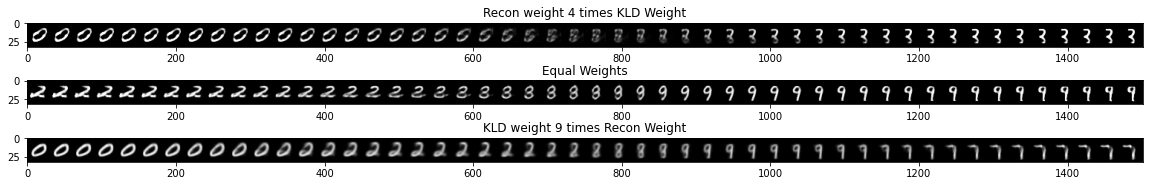

In [16]:
# One easy line (defined parametrically) is x(t) = t for t from -1 to 1
arr = np.transpose(np.array([np.linspace(-2,2)]*20))
tens1 = torch.tensor(arr).float().to(device)
print('Line from all -1 to all 1')
interpolate(tens1)

Traversing top ten dimensions


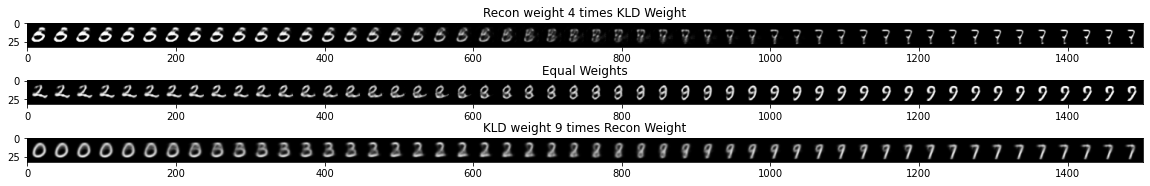

In [17]:
# Let's try only changing the top ten dimensions
arr = [np.linspace(-2,2)]*10
arr = np.hstack((np.array(arr).T, np.zeros((50,10))))
print('Traversing top ten dimensions')
tens2 = torch.tensor(arr).float().to(device)
interpolate(tens2)

Traversing bottom ten dimensions


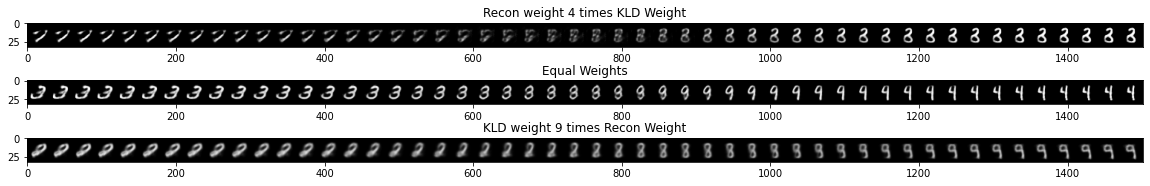

In [18]:
# Now for the bottom ten dimensions
arr = np.hstack((np.zeros((50,10)), np.array([np.linspace(-2,2)]*10).T))
print('Traversing bottom ten dimensions')
tens3 = torch.tensor(arr).float().to(device)
interpolate(tens3)

Cool, we have the neat slowly changing digit effect that we expected from the interpolation. We can also compare the latent spaces created by the different VAEs. I'lll only focus on the bottom two since the one with the higher reconstruction loss weight isn't quite as good. One interesting aspect is that for both VAEs, it seems like the digit 8 is at the center of the latent space. This reminds me of displaying digital numbers, where when you turn on all LED segments, you get the number 8!

Also, notice that we hit more digits in the interpolations for the bottom VAE (where we trained with a higher weight for the KLD loss). This suggests that maybe our encoder learned to create a more compact latent space. 

# Aggressively Tight Compression

I really like VAEs because they deal with what I find to be a central tenant of many problems: storing information effectively. Our encoder transforms the data in a way so that we still retain all the information specific to the input, but also so that our latent distribution matches a prior. Intuitively, we'd think that the info would have to be stored in a pretty smart way so that we can go from 784 dimensions to 20 (or fewer), and in my mind, the 'smart way' would lead to the creation of strong clusters for each digit class.

It's hard to visualize high dimensional data without doing another transformation like PCA, but that kind of defeats the point, as we want to see how information is stored in the current space. 

What happens if we choose a pretty aggressive latent dimension, like 3? My hunch is that our VAE is too simple as is (afterall, we only have fully connected layers), but let's just see what happens! If it works, then we can immediately visualize the latent space with a 3D scatter plot. 

Epoch: 0......Loss: 38.45246204


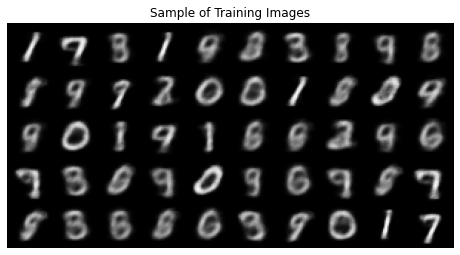

Epoch: 10......Loss: 30.57450645


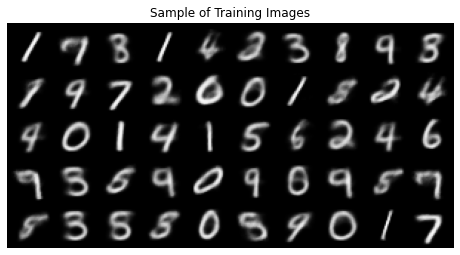

Epoch: 20......Loss: 30.01445044


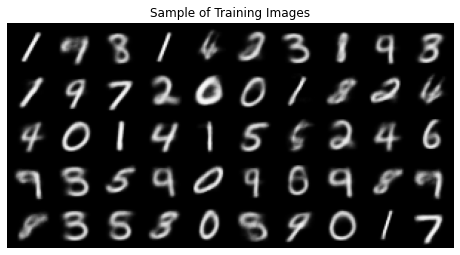

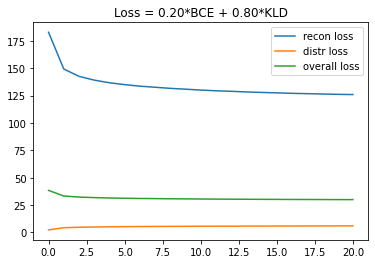

In [19]:
tight_vae = train(loader, latent_dim=3, epochs=21, kld_weight=0.8)

Wow! I'm pleasantly surprised, and impressed at the power of VAEs/neural networks. Just for fun, let's replicate the interpolations from above, as well as checking how well this VAE generates novel digits and reconstructs coded digits. 

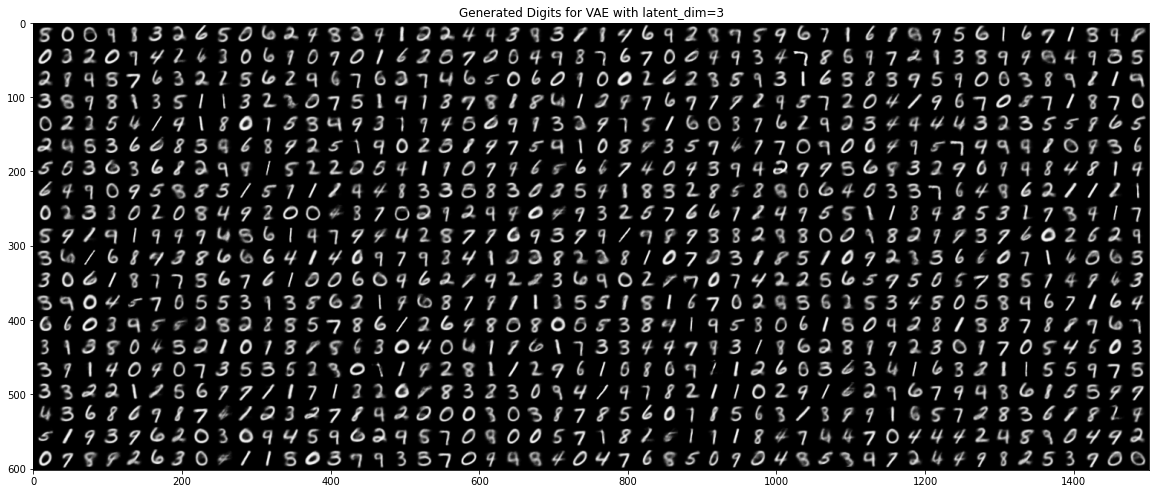

In [20]:
latent_codes = torch.randn(1000,3).to(device)
gen = tight_vae.decode(latent_codes).detach().cpu().view(1000,1,28,28)
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(vutils.make_grid(gen, padding=2, nrow=50).cpu(),(1,2,0)))
plt.title('Generated Digits for VAE with latent_dim=3')

plt.show()

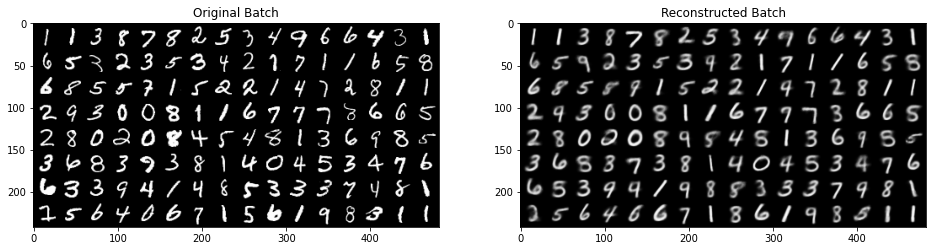

In [21]:
batch = next(iter(loader))[0].to(device)
recon_batch = tight_vae(batch)[0].cpu().detach().view(128,1,28,28)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Original Batch')
plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, nrow=16).cpu(),(1,2,0)))
plt.subplot(122)
plt.title('Reconstructed Batch')
plt.imshow(np.transpose(vutils.make_grid(recon_batch, padding=2, nrow=16).cpu(),(1,2,0)))
plt.show()

So we can see that reconstruction is ok, but it definitely makes some mistakes. Still better than I thought, for whatever that's worth.

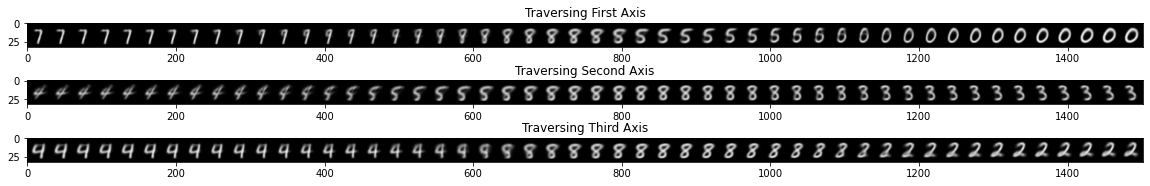

In [22]:
zeros = np.zeros((50,1))
spread = np.linspace(-2,2).reshape(50,1)
tight1 = torch.tensor(np.hstack((spread, zeros, zeros))).to(device).float()
tight2 = torch.tensor(np.hstack((zeros, spread, zeros))).to(device).float()
tight3 = torch.tensor(np.hstack((zeros, zeros, spread))).to(device).float()
out1, out2, out3 = [tight_vae.decode(x).cpu().detach().view(50,1,28,28) for x in \
                    [tight1, tight2, tight3]]
plt.figure(figsize=(20,3))
plt.subplot(311)
plt.title('Traversing First Axis')
plt.imshow(np.transpose(vutils.make_grid(out1, padding=2, nrow=50).cpu(),(1,2,0)))
plt.subplot(312)
plt.title('Traversing Second Axis')
plt.imshow(np.transpose(vutils.make_grid(out2, padding=2, nrow=50).cpu(),(1,2,0)))
plt.subplot(313)
plt.title('Traversing Third Axis')
plt.imshow(np.transpose(vutils.make_grid(out3, padding=2, nrow=50).cpu(),(1,2,0)))
plt.show()

Now for the visualization, we're going to need to collect some samples from each class, encode them, and plot them in a 3d scatter plot. 

In [23]:
dataset = datasets.MNIST(root='./data', download=True)
idx_ones = dataset.train_labels==1
ones_only = dataset.train_data[idx_ones]
print(ones_only.shape)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
torch.Size([6742, 28, 28])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


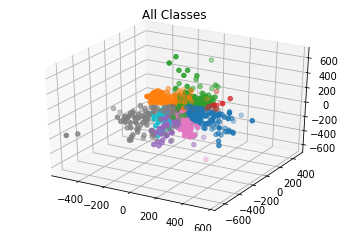

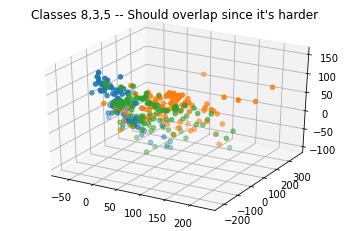

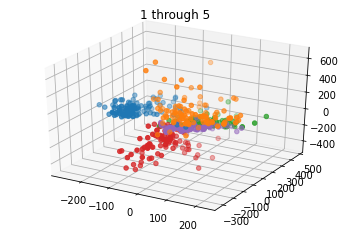

In [45]:
def get_sample_from_class(ind):
  idx = dataset.targets == ind
  whole_class = dataset.data[idx]
  sample = whole_class[:100]
  return sample.to(device).float()

def plot_latent_codes(class_inds, title):
  samples = [get_sample_from_class(ind) for ind in class_inds]
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  for sample in samples:
    latent_codes = tight_vae.reparameterize(*tight_vae.encode(sample.view(-1,784))).detach().cpu()
    ax.scatter(latent_codes[:,0], latent_codes[:,1], latent_codes[:,2])
  plt.title(title)
  plt.show()

plot_latent_codes(range(10), title='All Classes')
plot_latent_codes([8,3,5], 'Classes 8,3,5 -- Should overlap since it\'s harder')
plot_latent_codes([1,2,3,4,5], '1 through 5')

# Convolutional VAE


Let's see if we get better results by including conv layers in our VAE.

A reminder to my self from the GAN exercise with convs and tranposed convs:

* for a conv with stride $s$, padding  $𝑝$, and kernel size $k$, if the square tensor has side length $i$ at first, it will have side length $(𝑖+2𝑝−𝑘)/𝑠+1$ after the conv
* for a transposed convolution with kernel size $k$, padding of $p$, stride of $s$: if the square image has side length $i$ at first, it has side length $(i-1)*s + k - 2p$ after the tranposed convolution

In [0]:
class ConvVAE(nn.Module):
  def __init__(self, latent_dim=3):
    super(ConvVAE, self).__init__()
    # size is 1 x 28 x 28
    self.conv1 = nn.Conv2d(1, 4, 4, 2, 1)
    self.bn1 = nn.BatchNorm2d(4)
    # size is 4 x 14 x 14
    self.conv2 = nn.Conv2d(4, 16, 4, 2, 1)
    self.bn2 = nn.BatchNorm2d(16)
    # size is 16 x 7 x 7
    self.conv31 = nn.Conv2d(16, latent_dim, 7, 1, 0)
    self.bn31 = nn.BatchNorm2d(latent_dim)
    self.conv32 = nn.Conv2d(16, latent_dim, 7, 1, 0)
    self.bn32 = nn.BatchNorm2d(latent_dim)
    # size is latent_dim x 1 x 1
    self.deconv1 = nn.ConvTranspose2d(latent_dim, 16, 7, 1, 0)
    # size is 16 x 7 x 7
    self.deconv2 = nn.ConvTranspose2d(16, 4, 4, 2, 1)
    # size is 4 x 14 x 14
    self.deconv3 = nn.ConvTranspose2d(4, 1, 4, 2, 1)
    # size is 1 x 28 x 28

  def encode(self, x):
    e1 = F.leaky_relu(self.bn1(self.conv1(x)), 0.2, inplace=True)
    e2 = F.leaky_relu(self.bn2(self.conv2(e1)), 0.2, inplace=True)
    mu = F.leaky_relu(self.bn31(self.conv31(e2)), 0.2, inplace=True)
    logvar = F.leaky_relu(self.bn32(self.conv32(e2)), 0.2, inplace=True)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, z):
    if len(z.shape) == 2:
      z = z.view(z.shape[0], z.shape[1], 1, 1)
    d1 = F.relu(self.bn2(self.deconv1(z)))
    d2 = F.relu(self.bn1(self.deconv2(d1)))
    return torch.sigmoid(self.deconv3(d2))

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [41]:
convVAE = ConvVAE(10)
print(convVAE)

ConvVAE(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv31): Conv2d(16, 10, kernel_size=(7, 7), stride=(1, 1))
  (bn31): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv32): Conv2d(16, 10, kernel_size=(7, 7), stride=(1, 1))
  (bn32): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(10, 16, kernel_size=(7, 7), stride=(1, 1))
  (deconv2): ConvTranspose2d(16, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(4, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


Epoch: 0......Loss: 68.98113755


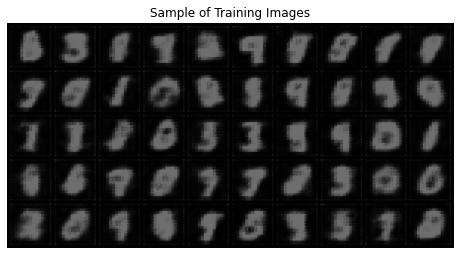

Epoch: 10......Loss: 40.28235696


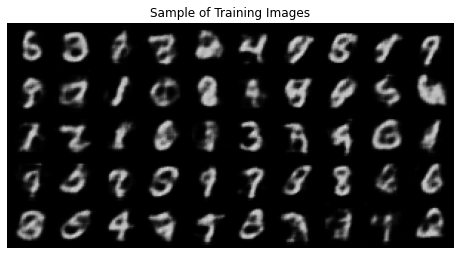

Epoch: 20......Loss: 38.32024910


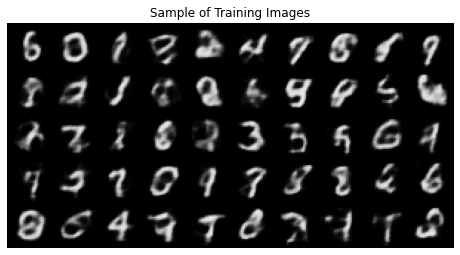

Epoch: 30......Loss: 37.71032343


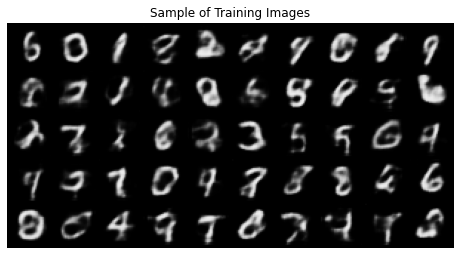

Epoch: 40......Loss: 37.35622220


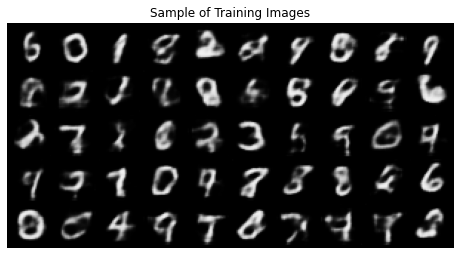

Epoch: 50......Loss: 37.18854797


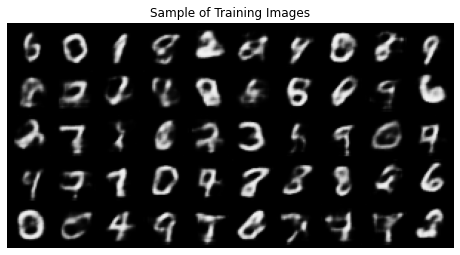

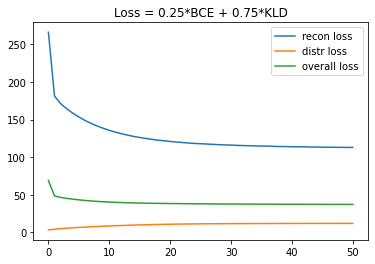

In [43]:
trained_convVAE = train(loader, vae=ConvVAE(20), latent_dim=20, lr=0.001,kld_weight=0.75)

Results are worse than before -- interesting! Also, without batch norm layers, the results were even worse. I don't really know what to make of this, but I guess its a valuable lesson in ML that adding intricacy doesn't always help!